## Numeryczne Rozwiązywanie Równań Różniczkowych Cząstkowych
### Uniwersytet Jagielloński 2021
Katedra Teorii Optymalizacji i Sterowania UJ


# Metoda elementów skończonych


## Laboratorium VII

https://www.hw.ac.uk/uk/schools/energy-geoscience-infrastructure-society/postgraduate-research/monitoring-and-modelling-of-ground-vibration-activity-from.htm

https://recruiting.fraunhofer.de/Vacancies/64286/Description/1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

%matplotlib inline

We need several packages to generate the mesh

https://github.com/nschloe/dmsh



In [ ]:
!pip install dmsh optimesh --quiet

In [ ]:
import dmsh
import meshio
import optimesh

In [ ]:
class Setup:
    def __init__(self):
        # geo = ....
        nodes, elements = dmsh.generate(geo, 0.05)

        self.nodes = np.array(nodes)

        self.elements = np.array(elements)

        self.material_properties = np.array([2000, 0.25])

        # Dirichlet BC
        # predicate_x = lambda x, y: ...
        predicate_y = predicate_x
        dirichlet = Setup.dirichlet(predicate_x, predicate_y, nodes, elements)
        self.dirichlet = np.array(dirichlet)

        # Neumann BC
        # predicate_x = lambda x, y: ...
        # predicate_y = lambda x, y: ...
        # value_x = lambda x, y: ...
        # value_y = lambda x, y: ...
        neumann = Setup.neumann(
            predicate_x, value_x, predicate_y, value_y, nodes, elements)
        self.neumann = np.array(neumann)

        # internal forces
        self.force = np.array([0.0, -0.2])

        # material properties
        self.young_modulus = 2000
        self.poisson_ratio = 0.25

    @staticmethod
    def dirichlet(predicate_x, predicate_y, nodes, elements):
        dirichlet = []
        # ...
        return dirichlet

    @staticmethod
    def neumann(predicate_x, value_x, predicate_y, value_y, nodes, elements):
        neumann = []
        # ...
        return neumann



setup = Setup()

Constants

In [ ]:
DIMENSION = 2
NODES_PER_ELEMENT = 3


Equation indecces mapping

In [ ]:
global_size = DIMENSION * len(setup.nodes)
ID = np.arange(global_size).reshape(-1, DIMENSION)

Finite Element class

In [ ]:
class FiniteElement:
    size = NODES_PER_ELEMENT * DIMENSION

    def __init__(self, e, setup):
        self.setup = setup

        # Calculate element element_eq_ids and coordinates 
        # element_eq_ids has the equations associated to element e
        self.eq_ids = np.zeros(FiniteElement.size)
        self.coord = np.zeros((NODES_PER_ELEMENT, DIMENSION))
        
        z = 0
        for j in range(NODES_PER_ELEMENT):
            J = setup.elements[e, j] # global node of element
            for direction in range(DIMENSION):
                self.eq_ids[z] = ID[J, direction]
                z += 1

            self.coord[j] = setup.nodes[J]

        self.B, self.D, self.area = self.make_B_and_D_matrices_and_area()
        self.K, self.F = self.make_stiffness_matrix()

    def make_B_and_D_matrices_and_area(self):
        i = 0; j = 1; k = 2
        x = 0; y = 1
        ex = self.setup.young_modulus
        nu = self.setup.poisson_ratio

        coord = self.coord
        ci = - coord[j, x] + coord[k, x]
        cj = - coord[k, x] + coord[i, x]
        ck = - coord[i, x] + coord[j, x]

        bi = coord[j, y] - coord[k, y]
        bj = coord[k, y] - coord[i, y]
        bk = coord[i, y] - coord[j, y]

        d = (ck * bj - cj * bk)
        area = d / 2

        B = (1 / d) * np.matrix([
            [bi,    0,  bj,    0,  bk,    0], 
            [ 0,   ci,   0,   cj,   0,   ck],
            [ci,   bi,  cj,   bj,  ck,   bk]
            ])

        D = ex / (1 - nu ** 2) * np.matrix([
            [ 1,  nu,            0],
            [nu,   1,            0],
            [ 0,   0, (1 - nu) / 2] 
            ])
        
        return B, D, area

    def make_stiffness_matrix(self):
        Ke = self.B.T * self.D * self.B * self.area

        Fe1 = (self.area * self.setup.force[0]
            *  np.array([1/3, 0.0, 1/3, 0.0, 1/3, 0.0])  # x mask
            )
            
        Fe2 = (self.area * self.setup.force[1]
            *  np.array([0.0, 1/3, 0.0, 1/3, 0.0, 1/3])  # y mask
            )
            
        Fe = Fe1 + Fe2
        
        return Ke, Fe

Building equation system

In [ ]:
K = np.zeros((global_size, global_size))
F = np.zeros((global_size, 1))

for e in range(len(setup.elements)):
    element = FiniteElement(e, setup)
   
    for i in range(FiniteElement.size):
        I = int(element.eq_ids[i])
        for j in range(FiniteElement.size):
            J = int(element.eq_ids[j])  
            # Adds element matrix K to global matrix K
            K[I, J] += element.K[i,j]
        # Adds load element vector F in F
        F[I] += element.F[i] 

Neumann Boundary Condition

In [ ]:
for node, dof, value in setup.neumann:
    i = ID[int(node), int(dof)]  # >_<

    # we want to increase force on the
    F[i] += value

Dirichlet Boundary Condition

In [ ]:
for node, direction, value in setup.dirichlet:    
    i = ID[int(node), int(direction)]  # >_<
    F[:, 0] = F[:, 0] - value * K[:, i]
    
    # we want to remove one equation
    K[i, :] = 0.0
    K[:, i] = 0.0
    K[i, i] = 1.0
    F[i] = value

Solving

In [ ]:
displacement = np.linalg.solve(K, F).reshape(len(setup.nodes), DIMENSION)

In [ ]:
# for vizualization
FACTOR = 1

displaced_nodes = setup.nodes + FACTOR * displacement

Plotting

In [ ]:
def view_mesh(nodes, elements, label, node_color='r', edge_color='k'):    
    graph = nx.Graph()
    for i, j, k in elements:        
        graph.add_edge(i,j)
        graph.add_edge(i,k)
        graph.add_edge(j,k)
    
    node_size = 20 + (1000 / len(setup.nodes))

    nx.draw(graph, pos=nodes, label=label, node_color=node_color, 
            edge_color=edge_color, node_size=node_size)

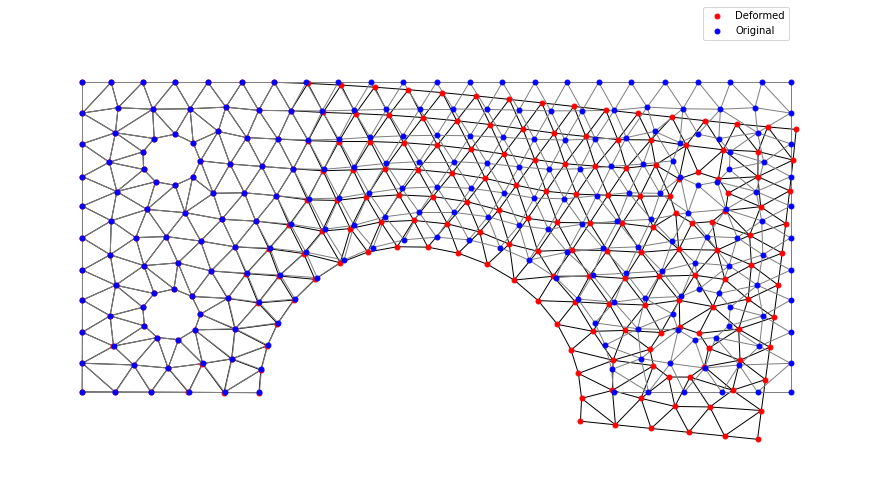

In [ ]:
f = plt.figure()
view_mesh(displaced_nodes, setup.elements, label='Deformed')
view_mesh(setup.nodes, setup.elements, label='Original', 
          node_color='b', edge_color='0.5')

ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()

plt.legend(handles=[handles[0], handles[2]], bbox_to_anchor=(0.8, 1),
           bbox_transform=plt.gcf().transFigure)

f.set_size_inches(12,6)
plt.show()

Stress

In [ ]:
def StressT3_EPT(element, UEl, s):

    StressE = element.D * element.B * UEl.T
       
    # Create 2D stress matrix
    S = np.zeros((DIMENSION, DIMENSION))
    S[0,0] = StressE[0]
    S[1,1] = StressE[1]
    S[1,0] = S[0,1] = StressE[2]
    
    # Stress in z direction is ZERO under plane stress conditions
    StressE = np.append(StressE, [[0]], axis=0)
    
    # Calculate principal stresses by finding the eigenvalues of S 
    w, v = np.linalg.eig(S)
    s1, s2 = w
    
    # Von Mises Stress
    SVME = np.sqrt(s1 ** 2 - s1*s2 + s2 ** 2)

    # Tresca Stress
    STRE = 0.5 * np.abs(s1 - s2)

    return StressE, SVME, STRE

In [ ]:
count = np.zeros(len(setup.nodes))
Sx   = np.zeros(len(setup.nodes))
Sy   = np.zeros(len(setup.nodes))
Sxy  = np.zeros(len(setup.nodes))
Sz   = np.zeros(len(setup.nodes))
SVM  = np.zeros(len(setup.nodes))
STR  = np.zeros(len(setup.nodes))

for e in range(len(setup.elements)):
    element = FiniteElement(e, setup)
    UEl = np.zeros(FiniteElement.size)
    
    z = 0
    for j in range(NODES_PER_ELEMENT):
        J = setup.elements[e,j]
        for i in range(DIMENSION):
            UEl[z] = displacement[J,i]
            z += 1
  
    # Calls method that calculates element
    # stress StressE, von Mises stress SVME
    # and Tresca stress STRE
    StressE, SVME, STRE = StressT3_EPT(
        element, 
        np.matrix(UEl), 
        setup
        ) 
   
    i, j, k = setup.elements[e]

    Sx[i] = Sx[i] + StressE[0]
    Sx[j] = Sx[j] + StressE[0]
    Sx[k] = Sx[k] + StressE[0]

    Sy[i] = Sy[i] + StressE[1]
    Sy[j] = Sy[j] + StressE[1]
    Sy[k] = Sy[k] + StressE[1]

    Sxy[i] = Sxy[i] + StressE[2]
    Sxy[j] = Sxy[j] + StressE[2]
    Sxy[k] = Sxy[k] + StressE[2]

    Sz[i] = Sz[i] + StressE[3]
    Sz[j] = Sz[j] + StressE[3]
    Sz[k] = Sz[k] + StressE[3]

    SVM[i] = SVM[i] + SVME
    SVM[j] = SVM[j] + SVME
    SVM[k] = SVM[k] + SVME

    STR[i] = STR[i] + STRE
    STR[j] = STR[j] + STRE
    STR[k] = STR[k] + STRE

    count[i] += 1
    count[j] += 1
    count[k] += 1

# Divide by counters
for i in range(len(setup.nodes)):
    Sx[i]  = Sx[i] /count[i]
    Sy[i]  = Sy[i] /count[i]
    Sxy[i] = Sxy[i]/count[i]
    Sz[i]  = Sz[i] /count[i]
    SVM[i] = SVM[i]/count[i]
    STR[i] = STR[i]/count[i]

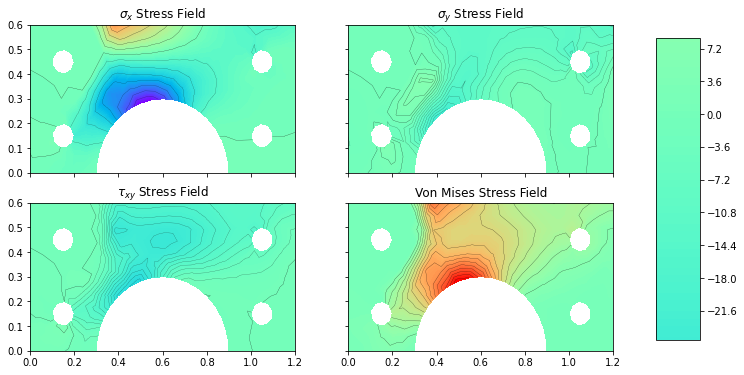

In [ ]:
# Only works for the LARGE CASE
x = setup.nodes[:,0]
y = setup.nodes[:,1]

# Choose with stress you want to vizualize: 
# Sx, Sy, Sxy, SVM or STR
f, axes = plt.subplots(2, 2, sharex='col', sharey='row')

((ax1, ax2), (ax3, ax4)) = axes

vmin_Sx = min(Sx)
vmin_Sy = min(Sy)
vmin_Sxy = min(Sxy)
vmin_SVM = min(SVM)
vmin_STR = min(STR)
vmin = min([vmin_Sx, vmin_Sy, vmin_Sxy, vmin_SVM, vmin_STR])

vmax_Sx = max(Sx)
vmax_Sy = max(Sy)
vmax_Sxy = max(Sxy)
vmax_SVM = max(SVM)
vmax_STR = max(STR)
vmax = max([vmax_Sx, vmax_Sy, vmax_Sxy, vmax_SVM, vmax_STR])

linewidths = 0.2
n_layers = 100
ax1.tricontour(x, y, setup.elements, Sx, 15, linewidths=linewidths, colors='k')
im1 = ax1.tricontourf(x, y, setup.elements, Sx, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax1.set_title(r'$\sigma_x$' + ' Stress Field')

ax2.tricontour(x, y, setup.elements, Sy, 15, linewidths=linewidths, colors='k')
im2 = ax2.tricontourf(x, y, setup.elements, Sy, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax2.set_title(r'$\sigma_y$' + ' Stress Field')

ax3.tricontour(x, y, setup.elements, Sxy, 15, linewidths=linewidths, colors='k')
im3 = ax3.tricontourf(x, y, setup.elements, Sxy, n_layers, cmap=plt.cm.rainbow, 
                      vmin=vmin, vmax=vmax)
ax3.set_title(r'$\tau_{xy}$' + ' Stress Field')

ax4.tricontour(x, y, setup.elements, SVM, 15, linewidths=linewidths, colors='k')
im4 = ax4.tricontourf(x, y, setup.elements, SVM, n_layers, cmap=plt.cm.rainbow,
                      vmin=vmin, vmax=vmax)
ax4.set_title('Von Mises Stress Field')

# ax4.tricontour(x, y, setup.elements, STR, 15, linewidths=linewidths, colors='k')
# im4 = ax4.tricontourf(x, y, setup.elements, STR, n_layers, cmap=plt.cm.rainbow,
#                      vmin=vmin, vmax=vmax)
# ax4.set_title('Tresca Stress Field')
           
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im2, cax=cbar_ax)
f.set_size_inches(12,6)
plt.show()